<a href="https://colab.research.google.com/github/patlewig/aim/blob/master/notebooks/AIM_Check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd

In [16]:
df = pd.read_csv("aimdb.tsv", sep='\t', names = ['SMILES', 'CASRN', 'othwer', 'other', 'AIM Fragments'])
df_aim = df[['SMILES','CASRN', 'AIM Fragments']]
df_aim['AIM_list'] = df_aim['AIM Fragments'].apply(lambda x: x.split(','))

df_aim = df_aim[0:5000]

#mask = df_aim['AIM_list'].apply(lambda x: '3' in x)
#df_aim = df_aim[mask].dropna()

df_aim.to_csv('AIM_list_5000_.csv')
df_aim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SMILES,CASRN,AIM Fragments,AIM_list
0,N1C(=O)NC(=O)C(F)=C1,51218,"5,10,15,43,58,172,174,176,206,210,3C","[5, 10, 15, 43, 58, 172, 174, 176, 206, 210, 3C]"
1,N(=O)(=O)c(ccc(O)c1N(=O)(=O))c1,51285,"19,23,34,13C","[19, 23, 34, 13C]"
2,Clc1c(Cl)cc(C(O)CNC(C)C)cc1,51296,"0,1,2,7,10,19,21,214,90C","[0, 1, 2, 7, 10, 19, 21, 214, 90C]"
3,c1cc(O)c(O)cc1C(O)CN(Cl)([H])([H])C(C)C,51309,"0,1,2,7,19,23,107,127,214","[0, 1, 2, 7, 19, 23, 107, 127, 214]"
4,CN1C2CC(CC1C3OC23)OC(=O)C(CO)c4ccccc4,51343,"0,1,2,7,8,11,19,40,171,173,174,82C","[0, 1, 2, 7, 8, 11, 19, 40, 171, 173, 174, 82C]"
...,...,...,...,...
4995,FC(C(Cl)C)F,430933,"0,2,12,14","[0, 2, 12, 14]"
4996,O=C(C(=O)C)C,431038,"0,118","[0, 118]"
4997,ClC(F)C(Cl)F,431061,"2,12,14","[2, 12, 14]"
4998,FC(=O)N(C)C,431141,"0,11,14,43,200","[0, 11, 14, 43, 200]"


In [22]:
df_chemo = pd.read_csv("AIM_V1_vs_fooba_5030.csv")
df_chemo = df_chemo.rename(columns={'M_SMILES':'SMILES'})
df_chemo['Chemo_list'] = df_chemo.apply(lambda x: x.index[x == 1].tolist(), axis=1)
df_chemo = df_chemo[['SMILES','Chemo_list']]
df_chemo


df_join = pd.merge(df_chemo,df_aim,on='SMILES',how='inner')

# Current Issue with Merging on CASRN:
# Difference in SMILES (Cl.NC(N)=N (Comptox/Chemotyper) vs  NC(N([H])([H])([H])Cl)=N (AIM) )
# Leads to difference in matching since Cl is disconnected in one (no halides)

# Alternative: Take SMILES From AIM_DB --> Write to SDF through RDKIT
# (How do I get CASRN in sdf file?)


df_join = df_join[['CASRN','SMILES','AIM_list', 'Chemo_list']]
df_join['Total AIM'] = df_join['AIM_list'].apply(lambda x: len(x))
df_join['Total Chemo'] = df_join['Chemo_list'].apply(lambda x: len(x))
df_join = df_join.drop_duplicates(subset=['SMILES'])
#df_join.to_csv('AIM_ChemoType_Bench_first600.csv')

#df_join

In [24]:
d = []
for row in df_join.itertuples():
    #combined = row.AIM_list+row.Chemo_list
    combined_uniques = list(set(row.AIM_list).symmetric_difference(set(row.Chemo_list)))
    #combined_uniques = (set(combined))
    d.append(combined_uniques)



df_join['Difference'] = d
#mask = df_join['AIM_list'].apply(lambda x: '5' in x)  #optional filter
#df_join = df_join[mask]       #Optional filter


df_join
df_join.to_excel('benchmark_smiles_aim_2_16_22_.xlsx')


exceptions = ['91C','91C_a','200C','200C_a','123C', '123C_a', 
                     '12','12_a','3_a','3','137', '146', '96E', '328C', '306C', 
                     '66E', '67E', '90E', '100C', '100Ca', '13C', '13C_a',
                     '13C_b','13C_c','13C_d','13C_e', '13C_f', '13C_g',
                     '13C_h', '8', '8_a', '8_b', '82C_a', '82C',
                     '183C', '183C_a', '171','171_a', '216', '216_a',
                     '2', '86C', '99C', '99C_a', '25', '30', '14C',
                     '14C_a', '40', '251C', '24_a', '34C', '34C_a']
for e in exceptions:
  df_join['Difference'] = df_join.Difference.apply(lambda x: [i for i in x if i != e])

print(df_join)

df_mismatch = df_join[df_join['Difference'].map(lambda d: len(d)) > 0]

full_match = round(1 -(len(df_mismatch)/len(df_join)),3)

#print(df_mismatch)

print('Percent full match: ' + str(100*full_match) + '%')

df_join

       CASRN  ...            Difference
0      51218  ...                    []
1      51285  ...                    []
2      51296  ...                    []
3      51343  ...                    []
4      51354  ...  [7C_a, 7C_b, 7C, 6C]
...      ...  ...                   ...
4745  426131  ...                    []
4746  427009  ...                    []
4747  427510  ...                    []
4748  428375  ...                    []
4749  428591  ...          [209C, 274C]

[4560 rows x 7 columns]
Percent full match: 91.10000000000001%


,CASRN,SMILES,AIM_list,Chemo_list,Total AIM,Total Chemo,Difference
0,51218,N1C(=O)NC(=O)C(F)=C1,"[5, 10, 15, 43, 58, 172, 174, 176, 206, 210, 3C]","[5, 10, 15, 43, 58, 172, 174, 176, 206, 210, 3C]",11,11,[]
1,51285,N(=O)(=O)c(ccc(O)c1N(=O)(=O))c1,"[19, 23, 34, 13C]","[19, 23, 34, 13C, 13C_b]",4,5,[]
2,51296,Clc1c(Cl)cc(C(O)CNC(C)C)cc1,"[0, 1, 2, 7, 10, 19, 21, 214, 90C]","[0, 1, 2, 7, 10, 19, 21, 214, 90C]",9,9,[]
3,51343,CN1C2CC(CC1C3OC23)OC(=O)C(CO)c4ccccc4,"[0, 1, 2, 7, 8, 11, 19, 40, 171, 173, 174, 82C]","[0, 1, 2, 7, 8, 11, 19, 40, 171, 173, 174, 82C]",12,12,[]
4,51354,O=C(O)C(NCC1O)C1,"[1, 2, 7, 10, 35, 171, 174, 6C, 7C]","[1, 2, 7, 10, 35, 171, 174, 7C_a, 7C_b]",9,9,"[7C_a, 7C_b, 7C, 6C]"
...,...,...,...,...,...,...,...
4745,426131,CC1CC2C3CCC(O)(C(=O)C)C3(C)CC(O)C2(F)C4(C)C=CC...,"[0, 1, 2, 5, 7, 14, 29, 76, 92, 171, 172, 176,...","[0, 1, 2, 5, 7, 14, 29, 76, 92, 171, 172, 176,...",15,15,[]
4746,427009,c(cc(c1C2(CC3)C4C5)CC4N3C)c(O)c1OC2CC5,"[0, 1, 2, 11, 19, 23, 25, 76, 171, 173, 174, 8...","[0, 1, 2, 11, 19, 23, 25, 76, 171, 173, 174, 8...",13,13,[]
4747,427510,C12(C)CCC3C4(C)C5CC5C(=O)C=C4C=CC3C1CCC2(C(=O)C)O,"[0, 1, 2, 5, 7, 29, 76, 92, 171, 172, 176, 82C...","[0, 1, 2, 5, 7, 29, 76, 92, 171, 172, 176, 82C...",13,13,[]
4748,428375,N1(C)CC(CCC)(c2cc(O)ccc2)CC1,"[0, 1, 11, 19, 23, 76, 171, 174, 90C]","[0, 1, 11, 19, 23, 76, 171, 174, 90C]",9,9,[]


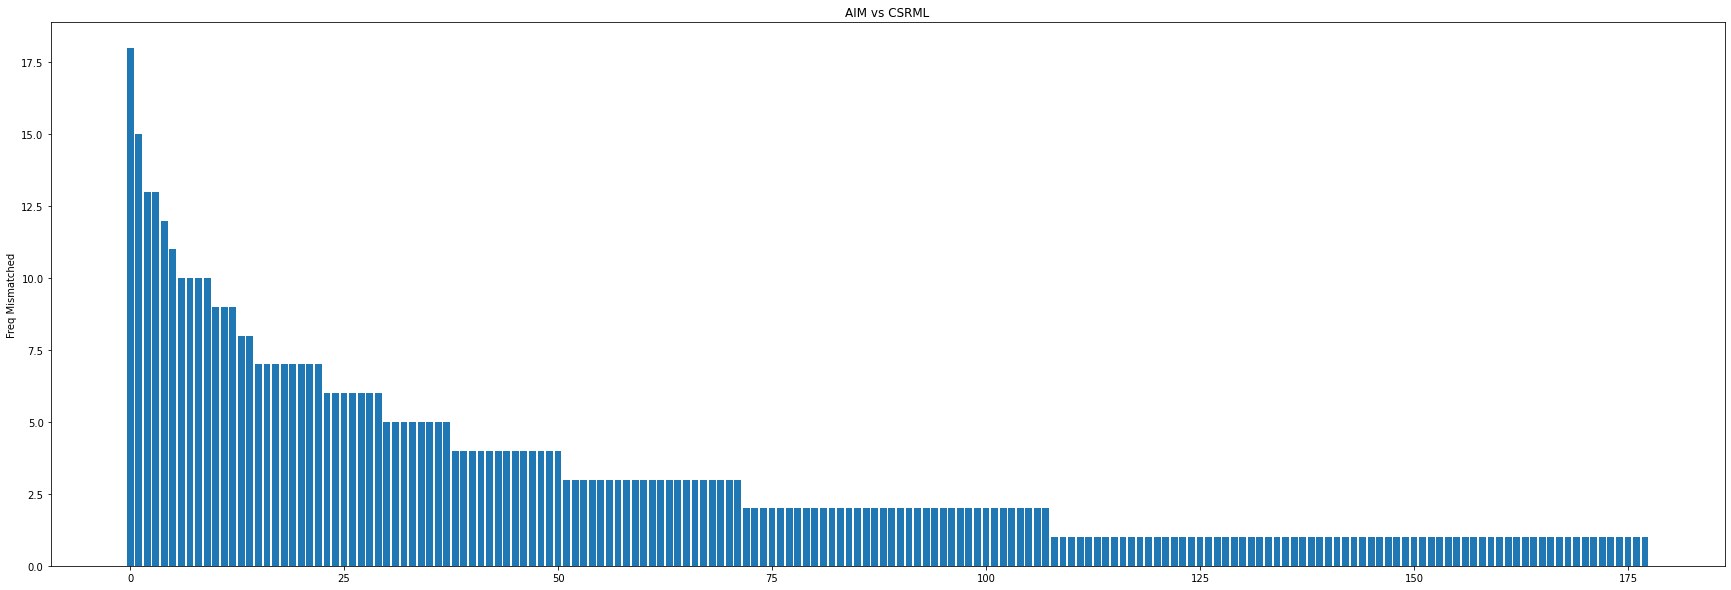

{'24': 18, '6C': 15, '26C': 13, '14': 13, '26C_b': 12, '31': 11, '211': 10, '166C': 10, '305C': 10, '51X': 10, '5C': 9, '43': 9, '3C': 9, '12C': 8, '225': 8, '40C': 7, '84': 7, '22C': 7, '9C': 7, '41': 7, '101C_a': 7, '101C': 7, '69E': 7, '26C_c': 6, '20': 6, '108C': 6, '90C': 6, '5': 6, '172': 6, '19C': 6, '29': 5, '181C': 5, '191C_a': 5, '191C': 5, '148C': 5, '95C': 5, '7': 5, '120C': 5, '7C_b': 4, '7C': 4, '174': 4, '89C': 4, '131C': 4, '38': 4, '215': 4, '36E': 4, '204': 4, '59': 4, '88E': 4, '228': 4, '77E': 4, '178': 3, '175': 3, '48': 3, '99': 3, '45X': 3, '179C': 3, '49C': 3, '21C': 3, '190C': 3, '87C': 3, '111C': 3, '115C': 3, '213': 3, '67': 3, '74E': 3, '84C': 3, '263C': 3, '61C': 3, '58E': 3, '197C': 3, '274C': 3, '23C': 2, '107C_b': 2, '107C': 2, '62E': 2, '124C': 2, '1': 2, '76': 2, '52C': 2, '0C': 2, '163C': 2, '56C': 2, '62C': 2, '210': 2, '96C': 2, '157C': 2, '157C_a': 2, '33C': 2, '51': 2, '19': 2, '92': 2, '37': 2, '217C': 2, '188C': 2, '279C': 2, '262C': 2, '126C': 

In [19]:
import matplotlib.pyplot as plt
import numpy as np
diff = []
for row in df_join["Difference"]:
  for fragment in row:
    diff.append(fragment)

import collections
diff_counter = collections.Counter(diff)
diff_counter = dict(sorted(diff_counter.items(), key=lambda item: -item[1]))
entries_to_remove = ('91C','91C_a','200C','200C_a','123C', '123C_a', 
                     '12','12_a','3_a','3','137', '146', '96E', '328C', '306C', 
                     '66E', '67E', '90E', '100C', '100Ca', '13C', '13C_a',
                     '13C_b','13C_c','13C_d','13C_e', '13C_f', '13C_g',
                     '13C_h', '8', '8_a', '8_b', '82C_a', '82C',
                     '183C', '183C_a', '171','171_a', '216', '216_a',
                     '2', '86C', '99C', '99C_a', '25', '30', '14C',
                     '14C_a', '40', '251C', '24_a', '101X')#,  '155C')

for k in entries_to_remove:
    diff_counter.pop(k, None)

keys = diff_counter.keys()
#print(keys)

key_len = np.arange(len(keys))
values = diff_counter.values()

plt.figure(figsize=(30, 10))
plt.bar(key_len,values)
plt.ylabel('Freq Mismatched')
plt.title('AIM vs CSRML')
#plt.xticks(key_len, keys)
plt.show()
print(diff_counter)

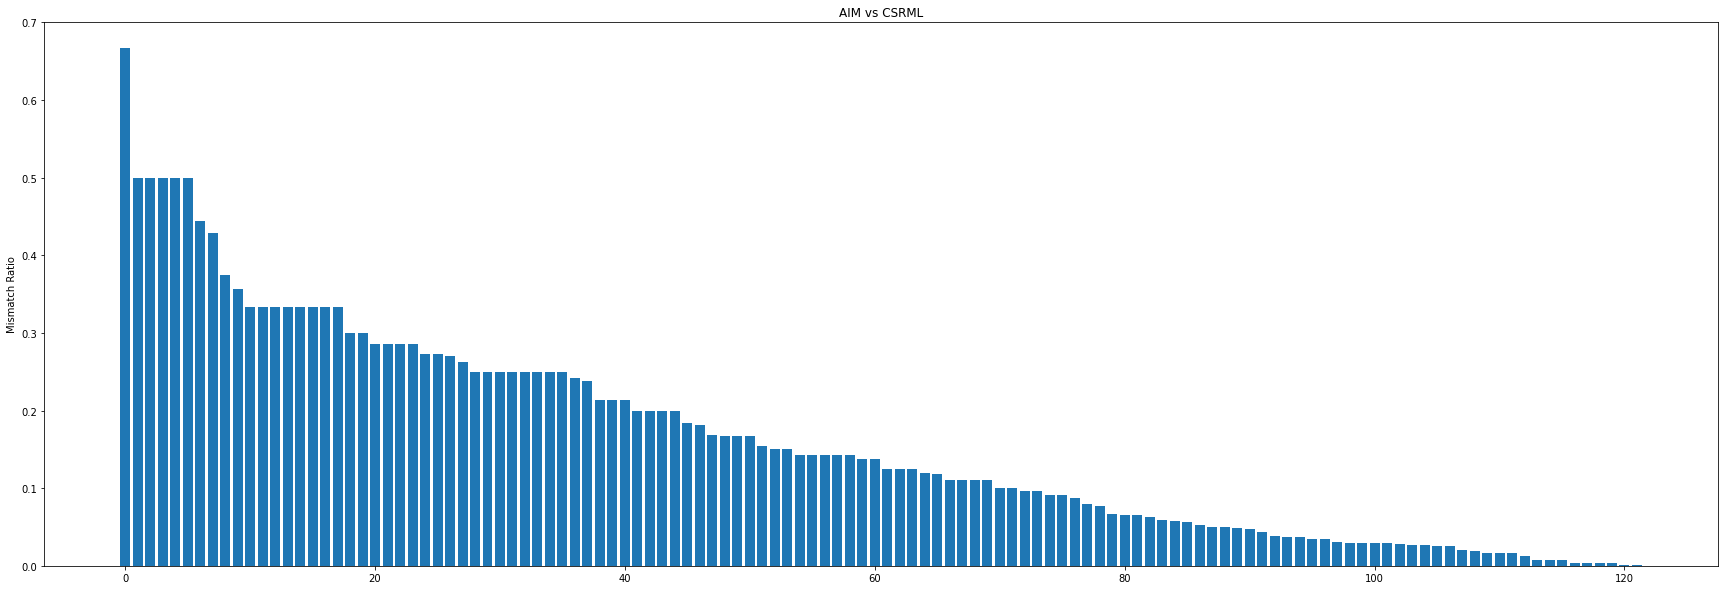

{'236C': 0.667, '23X': 0.5, '90X': 0.5, '18X': 0.5, '31X': 0.5, '218C': 0.5, '59': 0.444, '87C': 0.429, '19C': 0.375, '181C': 0.357, '52C': 0.333, '158C': 0.333, '90': 0.333, '18C': 0.333, '126C': 0.333, '10C': 0.333, '141': 0.333, '86': 0.333, '213': 0.3, '274C': 0.3, '166C': 0.286, '12C': 0.286, '131C': 0.286, '96C': 0.286, '108C': 0.273, '84C': 0.273, '305C': 0.27, '51X': 0.263, '82': 0.25, '179C': 0.25, '227C': 0.25, '33C': 0.25, '69C': 0.25, '47C': 0.25, '122': 0.25, '209C': 0.25, '6C': 0.242, '95C': 0.238, '5C': 0.214, '49C': 0.214, '61C': 0.214, '21C': 0.2, '120C': 0.2, '168C': 0.2, '53X': 0.2, '3C': 0.184, '124C': 0.182, '31': 0.169, '32C': 0.167, '85C': 0.167, '98': 0.167, '38': 0.154, '99': 0.15, '190C': 0.15, '151C': 0.143, '115C': 0.143, '48X': 0.143, '205C': 0.143, '226': 0.143, '36E': 0.138, '228': 0.138, '56C': 0.125, '315C': 0.125, '220C': 0.125, '211': 0.12, '103': 0.118, '118': 0.111, '111C': 0.111, '140': 0.111, '34E': 0.111, '107': 0.1, '27E': 0.1, '22C': 0.097, '9C

In [20]:
## mismatches / presence_in_list

def col_to_list(col):
  col_list = []
  for row in df_join[col]:
    for fragment in row:
      col_list.append(fragment)
  return col_list

AIM = col_to_list('AIM_list')
counter_aim = collections.Counter(AIM)
AIM_count = dict(counter_aim)
#print(AIM_count['269C'])

diff = col_to_list('Difference')
counter_diff = collections.Counter(diff)
diff_count = dict(counter_diff)
#print(diff_count['269C'])


fraction_mismatched = {k: round(diff_count[k] / float(AIM_count[k]),3) for k in diff_count if k in AIM_count}
fraction_sorted = dict(sorted(fraction_mismatched.items(), key=lambda item: -item[1]))
#print(fraction_mismatched)
entries_to_remove = ('91C','91C_a','200C','200C_a','123C', '123C_a', 
                     '12','12_a','3_a','3','137', '146', '96E', '328C', '306C', 
                     '66E', '67E', '90E', '100C', '100Ca', '13C', '13C_a',
                     '13C_b','13C_c','13C_d','13C_e', '13C_f', '13C_g',
                     '13C_h', '8', '8_a', '8_b', '82C_a', '82C',
                     '183C', '183C_a', '171','171_a', '216', '216_a',
                     '2', '86C', '99C', '99C_a', '25', '30', '14C',
                     '14C_a', '40', '251C', '24_a', '34C', '34C_a',
                     '35C', '35C_a', '101X', '106C_a', '157C',
                     '157C_a', '157C_b', '101C', '101C_a',
                     '106C', '106C_a', '106C_b', '23C', '62E', 
                     '7C', '7C_a', '7C_b', '121', '164',
                     '26C','26C_a','26C_b','26C_c','26C_d',
                     '191C', '191C_a', '107C_a', '107C_b', '107C',
                     '40C')
#121, 164 - both Nitroso, N+5 Valence

for k in entries_to_remove:
    fraction_sorted.pop(k, None)



keys = fraction_sorted.keys()

key_len = np.arange(len(keys))
values = fraction_sorted.values()

plt.figure(figsize=(30, 10))
plt.bar(key_len,values)
plt.ylabel('Mismatch Ratio')
plt.title('AIM vs CSRML')
#plt.xticks(key_len, keys)
plt.show()



print(fraction_sorted)  # Fraction > 1: CSRML overmatching (found more than there actually are AIM)


In [ ]:
fragments = []
for row in df_join["Difference"]:
  for fragment in row:
    fragments.append(fragment)
  #print(df_benchmark["Organic functional groups (US EPA)"][row])
i = list(set(fragments)) #list of unique fragments
duplicates = ['137', '146', '96E', '328C', '306C', '66E', '67E', '90E']
#maybe some AIM wrong: 3, 8, 23C, 76, 2, 124C, 216, 29
aim_error = ['1','2','3','8', '20','29','211', '12','174', '76','175', '101X','99','5C','14C','191C','40C', '181C', '84', '191C', '62E', '121', '178', '43', '25', '151C', '155C', '82C']  # maybe 121; CAS 69749, 61734,75172, 50760, 58253 is wrong on AIM, (weird aromatic)
final_list = list(set(i) - set(duplicates)- set(aim_error))
print(len(final_list))   # Length of list (# unique different fragments)



163


In [86]:
df_join
fragments = []
for row in df_join["AIM_list"]:
  for fragment in row:
    fragments.append(fragment)

print(fragments)
diffs = []

for i in fragments:
  selection = [i]

  mask = df_join['Difference'].apply(lambda x: any(item for item in selection if item in x))

  df_diff = df_join[mask]

  diff_total = df_diff.shape[0]

  chemo_mask = df_diff['Chemo_list'].apply(lambda x: any(item for item in selection if item in x))

  diff_chemo = df_diff[chemo_mask].shape[0]
  diff_aim = diff_total - diff_chemo
  diffs.append([diff_total,diff_chemo,diff_aim])

print(diffs)

['5', '10', '15', '43', '58', '172', '174', '176', '206', '210', '3C', '19', '23', '34', '13C', '0', '1', '2', '7', '10', '19', '21', '214', '90C', '0', '1', '2', '7', '8', '11', '19', '40', '171', '173', '174', '82C', '1', '2', '7', '10', '35', '171', '174', '6C', '7C', '19', '21', '36', '19', '21', '36', '1', '2', '7', '9', '19', '23', '214', '90C', '1', '2', '7', '9', '19', '23', '214', '90C', '0', '1', '2', '7', '10', '19', '23', '35', '40', '214', '4C', '14C', '90C', '168C', '190C', '0', '1', '2', '7', '10', '19', '23', '214', '90C', '19', '21', '36', '1', '11', '171', '174', '1', '2', '9', '19', '23', '26', '35', '55', '6C', '52C', '1', '11', '12', '19', '216', '0', '1', '5', '10', '43', '45', '171', '172', '174', '176', '206', '210', '160C', '0', '1', '2', '7', '11', '19', '40', '171', '174', '82C', '1', '9', '19', '23', '90C', '0', '1', '2', '9', '19', '90C', '1', '2', '9', '19', '35', '42', '6C', '0', '19', '24', '25', '43', '1', '9', '19', '23', '90C', '0', '1', '11', '19', '

In [103]:
diffs_dict = dict(zip(fragments,diffs))
diffs_dict = {key:val for key, val in diffs_dict.items() if val != [0, 0, 0]}  #Get rid of ones with no diffs

diffs_dict
# [total diff, AIM MISSING, CSRML MISSING]

{'0C': [2, 0, 2],
 '1': [2, 0, 2],
 '100': [1, 0, 1],
 '101C': [7, 0, 7],
 '101X': [2, 0, 2],
 '103': [2, 0, 2],
 '106C': [1, 0, 1],
 '107': [1, 0, 1],
 '107C': [2, 0, 2],
 '108C': [6, 6, 0],
 '10C': [1, 1, 0],
 '11': [2, 2, 0],
 '111C': [3, 0, 3],
 '115C': [3, 0, 3],
 '118': [1, 1, 0],
 '120C': [5, 4, 1],
 '121': [1, 0, 1],
 '122': [1, 0, 1],
 '124C': [2, 0, 2],
 '126C': [2, 0, 2],
 '12C': [8, 6, 2],
 '131C': [4, 0, 4],
 '14': [13, 0, 13],
 '140': [1, 0, 1],
 '141': [2, 0, 2],
 '151C': [1, 0, 1],
 '157C': [2, 0, 2],
 '158C': [1, 1, 0],
 '164': [1, 0, 1],
 '166C': [10, 10, 0],
 '168C': [1, 0, 1],
 '172': [6, 3, 3],
 '173': [1, 0, 1],
 '174': [4, 1, 3],
 '175': [3, 0, 3],
 '178': [3, 0, 3],
 '179C': [3, 2, 1],
 '17C': [1, 0, 1],
 '18': [1, 0, 1],
 '181C': [5, 1, 4],
 '18C': [1, 1, 0],
 '18X': [1, 1, 0],
 '19': [2, 1, 1],
 '190C': [3, 0, 3],
 '191C': [5, 0, 5],
 '197C': [3, 0, 3],
 '19C': [6, 1, 5],
 '1C': [2, 0, 2],
 '20': [6, 2, 4],
 '204': [4, 4, 0],
 '205C': [1, 0, 1],
 '206': [1, 0,

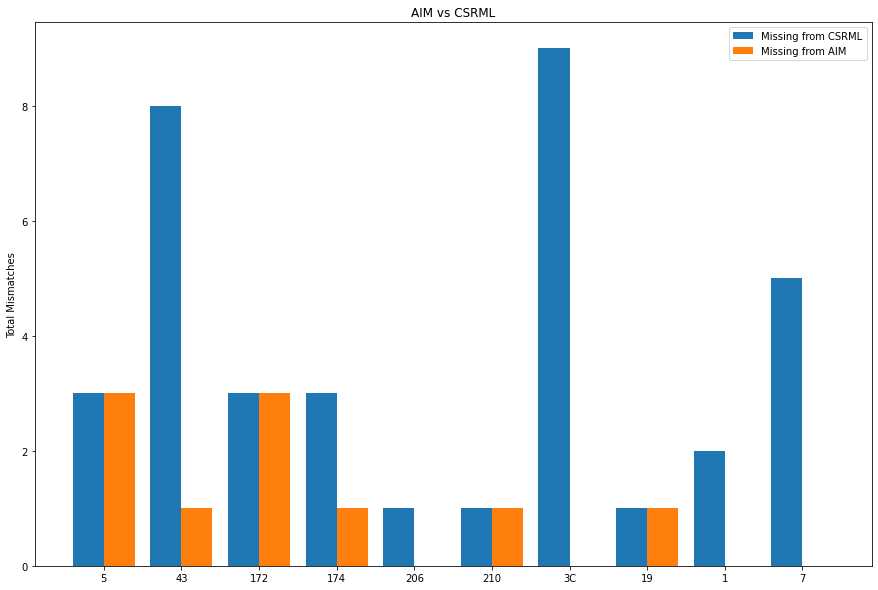

In [125]:
keys = diffs_dict.keys()

key_len = np.arange(len(keys))

n = 10
first_n_pairs = {k: diffs_dict[k] for k in list(diffs_dict)[:n]}

keys = first_n_pairs.keys()

key_len = np.arange(len(keys))


values = list(first_n_pairs.values())
values_0 = [item[0] for item in values]
values_1 = [item[1] for item in values]
values_2 = [item[2] for item in values]









labels = ['Missing from CSRML','Missing from AIM']
plt.figure(figsize=(15, 10))
plt.bar(key_len - 0.2, values_2, 0.4)
plt.bar(key_len + 0.2, values_1, 0.4)

plt.ylabel('Total Mismatches')
plt.title('AIM vs CSRML')
plt.legend(labels)
plt.xticks(key_len, keys)
plt.show()

In [126]:
AIM_count

{'0': 2550,
 '0C': 23,
 '0E': 3,
 '0X': 4,
 '1': 2666,
 '10': 445,
 '100': 21,
 '100C': 18,
 '100X': 1,
 '101': 12,
 '101C': 7,
 '101X': 2,
 '102': 30,
 '102C': 3,
 '103': 17,
 '103C': 1,
 '103X': 1,
 '104C': 1,
 '105': 1,
 '106C': 1,
 '107': 10,
 '107C': 3,
 '108C': 22,
 '109': 2,
 '10C': 3,
 '10X': 3,
 '11': 538,
 '110C': 5,
 '111': 1,
 '111C': 27,
 '112C': 7,
 '113C': 2,
 '115': 1,
 '115C': 21,
 '116': 4,
 '117': 9,
 '118': 9,
 '118C': 1,
 '119': 2,
 '11C': 1,
 '12': 279,
 '120C': 25,
 '121': 1,
 '122': 4,
 '122C': 12,
 '123C': 18,
 '124C': 11,
 '125C': 9,
 '126C': 6,
 '127C': 5,
 '128C': 5,
 '12C': 28,
 '13': 47,
 '130': 4,
 '130C': 7,
 '131': 1,
 '131C': 14,
 '132': 1,
 '133': 1,
 '134C': 1,
 '135': 1,
 '135C': 1,
 '136': 3,
 '136C': 7,
 '137C': 1,
 '13C': 58,
 '13E': 1,
 '14': 370,
 '140': 9,
 '140C': 1,
 '141': 6,
 '141C': 1,
 '142C': 6,
 '143C': 11,
 '145C': 1,
 '146C': 1,
 '149': 9,
 '149C': 1,
 '14C': 271,
 '14E': 2,
 '14X': 1,
 '15': 20,
 '150': 1,
 '151': 2,
 '151C': 7,
 '1